In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, welch
from math import radians, cos, sin, asin, sqrt
import os #Minun virtuaaliympäristö ei jostain syystä löytänyt tiedostoa ilman tätä importtia.
import folium

In [127]:

data = pd.read_csv('fixeddata.csv') #Lukee tiedoston
data = data.dropna(subset=['Latitude (°)', 'Longitude (°)']) #Poistaa tyhjät lokerot sijaintitiedoista

start_lat = data['Latitude (°)'].mean()
start_long = data['Longitude (°)'].mean() #Määrittää aloituspaikan matkan keskiarvon perusteella.

my_map = folium.Map(location = [start_lat,start_long], zoom_start = 18) #Luo kartan
folium.PolyLine(data[['Latitude (°)','Longitude (°)']], color = 'red', weight = 2.5, opacity = '1').add_to(my_map) #Piirtää viivan
my_map.save('kartta.html') #Tallentaa tiedostoon

In [128]:
data = pd.read_csv('fixeddata.csv')
#Varastoidaan tiedoston osat muuttujiin
time = data['Time (s)']
acc_x = data['Linear Acceleration x (m/s^2)']
acc_y = data['Linear Acceleration y (m/s^2)']
acc_z = data['Linear Acceleration z (m/s^2)']
lat = data['Latitude (°)']
lon = data['Longitude (°)']
speed = data['Velocity (m/s)']

In [129]:
acc = acc_y  #Valitaan akseli

In [130]:
# Suodatin
def suodatin(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

fs = 200  # Taajuus. csv tiedostossa n. 33k otetta 167 sekunnissa.
filtered_acc = suodatin(acc, cutoff=3, fs=fs)

# Askelmäärä suodattimella
peaks, _ = find_peaks(filtered_acc, distance=fs*0.1)
step_count_filtered = len(peaks)

# Askelmäärä fourierilla
f, Pxx = welch(acc, fs, nperseg=1024)
dominant_freq = f[np.argmax(Pxx)]
step_count_fft = int(dominant_freq * len(time) / fs)

# Keskinopeus
average_speed = speed.mean() * 3.6

# Kokonaismatka
distance = speed.sum()

# Askelmitta
step_length = distance / step_count_filtered if step_count_filtered > 0 else np.nan




Askelmäärä suodatettuna: 344
Askelmäärä fourier-analyysillä): 331
Keskinopeus (km/h): 4.84
Kokonaismatka (m): 224.66
Askelpituus (m): 0.65


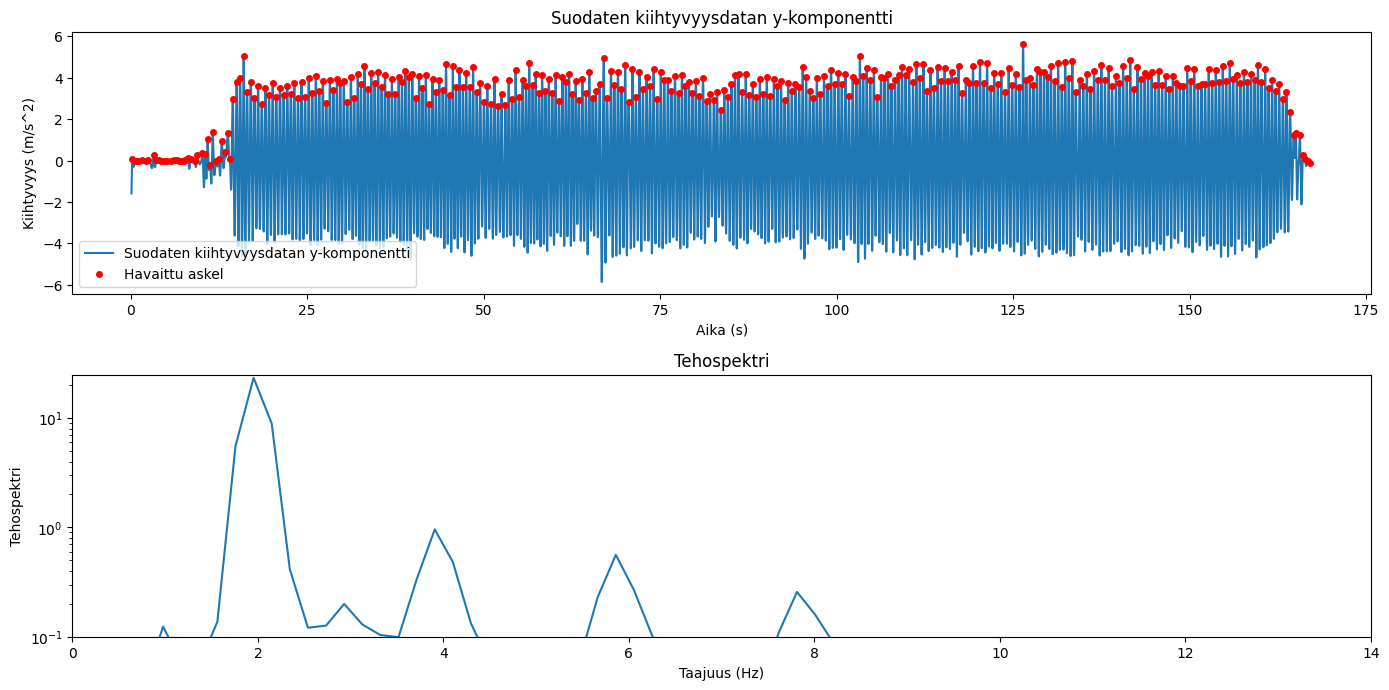

In [131]:
plt.figure(figsize=(14, 10))
print(f"Askelmäärä suodatettuna: {step_count_filtered}")
print(f"Askelmäärä fourier-analyysillä): {step_count_fft}")
print(f"Keskinopeus (km/h): {average_speed:.2f}")
print(f"Kokonaismatka (m): {distance:.2f}")
print(f"Askelpituus (m): {step_length:.2f}")
#askeleet
plt.subplot(3, 1, 1)
plt.plot(time, filtered_acc, label='Suodaten kiihtyvyysdatan y-komponentti')
plt.plot(time[peaks], filtered_acc[peaks], 'r.', markersize=8, label='Havaittu askel')
plt.xlabel('Aika (s)')
plt.ylabel('Kiihtyvyys (m/s^2)')
plt.title('Suodaten kiihtyvyysdatan y-komponentti')
plt.legend()

# tehospektri
plt.subplot(3, 1, 2)
plt.semilogy(f, Pxx)
plt.xlim(0,14)
plt.ylim(0.1,25)
plt.xlabel('Taajuus (Hz)')
plt.ylabel('Tehospektri')
plt.title('Tehospektri')


plt.tight_layout()
plt.savefig('data.png')
plt.show()

display(my_map)